# Present Sweep Analysis and Plotting

This notebook produce the results in Figure 5: demonstration of gain in performance from separation of inference.


In [1]:
# Install required packages if needed
# pip install matplotlib h5py scipy seaborn scikit-learn --no-index

## Preparation

Import modules:


In [2]:
from mirrored_langevin_rnn.utils.visualization.styling import hide_labels
from mirrored_langevin_rnn.utils.visualization import (
    PlotStyle,
    add_vertical_markers,
)
from mirrored_langevin_rnn.utils.data_pipeline.present_sweep_analysis import (
    plot_L1_curves,
    compute_accuracy_heatmap,
    compute_l1_heatmap,
    plot_accuracy_heatmap,
    plot_concentration_heatmap,
    compute_rankacc_heatmap,
    compute_auc_heatmap,
    compute_rank_accuracy_curve,
    compute_auc_curve,
    compute_binarized_presence_auc_curve,
    plot_presence_assessed_curves,
    compute_binarized_auc_heatmap
)
from mirrored_langevin_rnn.utils.data_pipeline.data_io import (
    merge_model_batches,
    _combine_batches,
    collect_C_all,
    collect_theta_all
)
import sys
import logging
from pathlib import Path
from typing import List

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import contour
from matplotlib.axes import Axes
from matplotlib.colors import Normalize

# Add project root to path for imports
BASE_DIR = Path.cwd().parent  # go up one level
sys.path.append(str(BASE_DIR))

In [3]:
# Configure logging
logging.basicConfig(
    level=logging.WARNING,  # Set default level to WARNING
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%H:%M:%S'
)

# Create logger for this notebook
logger = logging.getLogger('present_sweep_analysis')

# To see info messages during development, uncomment the next line:
# logger.setLevel(logging.INFO)

logger.info("Logging configured - default level: WARNING")

File I/O configuration:


In [4]:
# Setup directory paths
raw_input_dir = BASE_DIR / "data" / "present_sweep" / "sparse_binary" / "batch"
output_base_dir = BASE_DIR / "data" / "present_sweep" / "sparse_binary" / "combined"

# Create output directory if it doesn't exist
output_base_dir.mkdir(parents=True, exist_ok=True)

figures_dir = BASE_DIR / "figures" / "present_sweep" / "sparse_binary"


# Define model directories and output files
model_configs = {
    "naive": {
        "input": raw_input_dir /  "naive",
        "pattern": "slam_naive_results_batch*.h5",
        "output": output_base_dir / "slam_naive_results.h5"
    },
    "poisson": {
        "input": raw_input_dir / "poisson",
        "pattern": "poisson_results_batch*.h5",
        "output": output_base_dir / "poisson_results.h5"
    },
    "circuit": {
        "input": raw_input_dir / "circuit",
        "pattern": "slam_circuit_results_batch*.h5",
        "output": output_base_dir / "slam_circuit_results.h5"
    }
}

logger.info(f"Input directory: {raw_input_dir}")
logger.info(f"Output directory: {output_base_dir}")
for model_name, config in model_configs.items():
    logger.info(f"{model_name}: {config['input']} -> {config['output']}")

In [5]:
# Basic shared configuration - only the most obvious duplicates
timepoint_1 = 11
timepoint_2 = 61
n_timepoint = 76
true_concentration = 40.0


hide_label = True

# Model colors for consistency
separatedColor = "#D95319"
# baselineColor = "steelblue"  
baselineColor = "#1B9E77"
circuitColor = "#7570b3"
# circuitColor = "#E13960"

# Shared contour levels for heatmaps
contour_levels = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

logger.info(f"Basic configuration loaded:")
logger.info(f"  Timepoints: {timepoint_1}, {timepoint_2}")
logger.info(f"  Colors: Separated={separatedColor}, Baseline={baselineColor}, Circuit={circuitColor}")

In [6]:
if hide_label:
    figures_dir = figures_dir / "labels_hidden"
else:
    figures_dir = figures_dir / "labels_visible"
figures_dir.mkdir(parents=True, exist_ok=True)

Functions:


Heatmap plotting functions:

In [7]:
def colorbar_config(norm, fig_rank, ax_rank, contour_levels=contour_levels, ticks=None):
    cbar_rank = fig_rank.colorbar(
        ax_rank.collections[0], ax=ax_rank, shrink=0.9, aspect=9)
    cbar_rank.mappable.set_norm(norm)
    cbar_rank.set_ticks(contour_levels)
    cbar_rank.ax.tick_params(width=0)
    if ticks is not None:
        cbar_rank.set_ticklabels(ticks, fontsize=16)
    else:
        cbar_rank.set_ticklabels(
            ['0.2', "", '0.4', "", '0.6', "", '0.8', "", '1.0'], fontsize=16)
    
    cbar_rank.outline.set_linewidth(2)
    return cbar_rank


def add_contour_lines_to_colorbar(colorbar, contour_levels, norm, 
                                  label_offset=0.02, highlight_level=0.8,
                                  highlight_color='yellowgreen'):
    for level in contour_levels:
        # normalized_level = norm(level)
        if level == highlight_level:
            colorbar.ax.axhline(level, xmin=0.6, xmax=1,
                                color=highlight_color, linestyle='solid', linewidth=2)
        else:
            colorbar.ax.axhline(level, xmin=0.6, xmax=1,
                                color='black', linestyle='solid', linewidth=2)

## Merge Batch Files


In [8]:
# Merge naive model results
naive_merged = merge_model_batches("naive", model_configs["naive"])
# Merge poisson model results
poisson_merged = merge_model_batches("poisson", model_configs["poisson"])
# Merge circuit model results (if files exist)
slam_circuit = merge_model_batches("circuit", model_configs["circuit"])

## Inference performance assessed by concentration

Preparation


In [9]:
# Define model plotting configuration
model_keys = ["poisson", "naive", "circuit"]
model_labels = ["Non-separated", "Separated", "Separated (Circuit implementation)"]
model_colors = [baselineColor, separatedColor, circuitColor]
model_combined_output_files = [model_configs[key]["output"] for key in model_keys]

logger.info("Model plotting configuration:")
for model_key, label, color in zip(model_keys, model_labels, model_colors):
    logger.info(f"  {model_key}: {label} ({color})")

logger.info(f"Files to plot: {len(model_combined_output_files)} models")
logger.info(f"Labels: {model_labels}")
logger.info(f"Colors: {model_colors}")

In [10]:
# Timepoint configuration
timepoints = [timepoint_1, timepoint_2]
logger.info(f"Analysis timepoints: {timepoints}")
logger.info(f"Total timepoints in analysis: {n_timepoint}")
logger.info(f"True concentration: {true_concentration}")

In [11]:
if logger.isEnabledFor(logging.DEBUG):
    with h5py.File(model_combined_output_files[0], "r") as f:
        logger.debug()(f"Keys in second model file: {list(f.keys())}")
        runs = f["runs"]
        logger.debug()(f"Run keys: {list(runs.keys())[:3]}...")  # Show first 3 runs
        logger.debug(f"Example run keys: {list(runs['num_low=0_num_high=10_rep=0'].keys())}")
        logger.debug()(f"C shape: {runs['num_low=0_num_high=10_rep=0']['C'].shape}")
        logger.debug()(f"Keys in first model file: {list(f.keys())}")

    with h5py.File(model_combined_output_files[1], "r") as f:
        runs = f["runs"]
        logger.debug()(f"Run keys: {list(runs.keys())[:3]}...")  # Show first 3 runs
        logger.debug()(f"Example run keys: {list(runs['num_low=0_num_high=10_rep=0'].keys())}")
        logger.debug()(f"Theta shape: {runs['num_low=0_num_high=10_rep=0']['Theta'].shape}")
        theta = np.array(runs["num_low=0_num_high=10_rep=0"]["Theta"])
        logger.debug()(f"Theta sample (first 5x5): \n{theta[:5, :5]}")

### Plotting slices


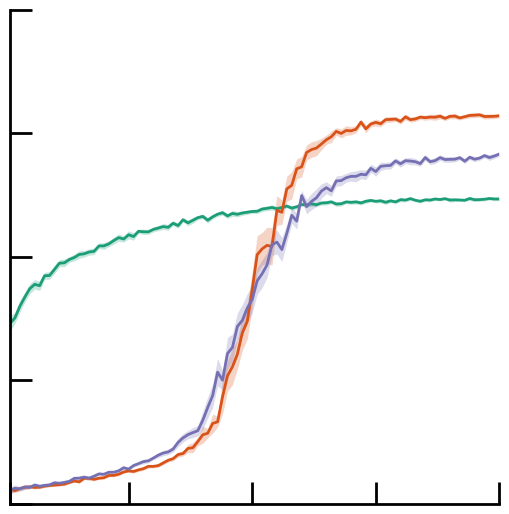

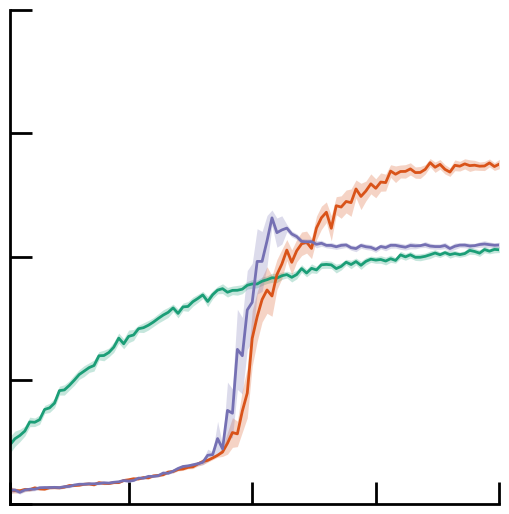

In [12]:
for snapshot_idx in timepoints:
    filename = f"L1_error_at_timepoint_{snapshot_idx}.svg"
    fig, ax = plot_L1_curves(
        model_combined_output_files,
        labels=model_labels,
        colors=model_colors,
        snapshot_idx=snapshot_idx,
        true_conc=true_concentration,
        show_std=True,
        figsize=(6, 6)
    )
    
    if hide_label:
        hide_labels(ax)

    # Add a legend if needed
    # ax.legend(fontsize=16, frameon=False)
    # plt.title(f"L1 Error at Time Point (t={snapshot_idx})", fontsize=16)
    fig.savefig(figures_dir / filename, bbox_inches='tight', format='svg')

### Concentration accuracy score heatmaps


In [13]:
model_concentration_data = {}
concentration_accuracy_heatmaps = {}
concentration_l1_heatmaps = {}

for model_key in model_configs.keys():
    C_all, n_high_vals = collect_C_all(model_configs[model_key]["output"])
    model_concentration_data[model_key] = C_all
    concentration_accuracy_heatmaps[model_key] = compute_accuracy_heatmap(
        C_all, c_truth=true_concentration, n_timepoints=n_timepoint
    )
    concentration_l1_heatmaps[model_key] = compute_l1_heatmap(
        C_all, c_truth=true_concentration, n_timepoints=n_timepoint
    )

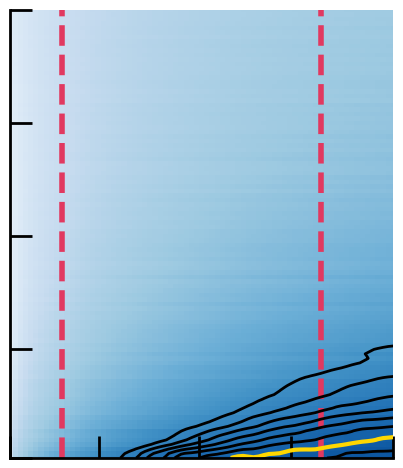

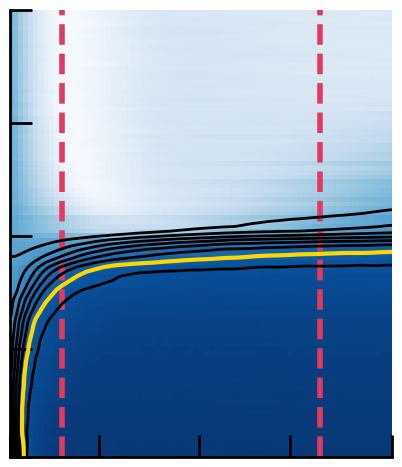

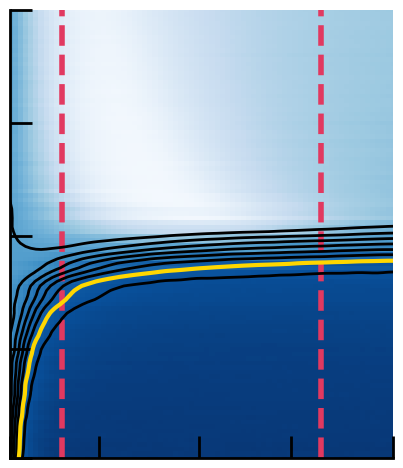

In [14]:
vmin, vmax = 0, 40
logger.info(f"Using color scale: vmin={vmin:.3f}, vmax={vmax:.3f}")

# Create a shared colormap normalization
norm = Normalize(vmin=vmin, vmax=vmax)

contour_levels_l1 = [0, 5, 10, 15, 20, 25, 30, 35, 40]
ticks = ['0', '', '10', '', '20', '', '30', '', '40']

model_titles = ["Poisson model accuracy",
                "Naïve model accuracy",  "Circuit model accuracy"]

for model_key, title in zip(model_keys, model_titles):
    fig, ax = plot_concentration_heatmap(
        concentration_l1_heatmaps[model_key],
        heatmap_contour=concentration_accuracy_heatmaps[model_key],
        # heatmap_contour=concentration_l1_heatmaps[model_key],
        title=title,
        xlabel="Time after odour onset (ms)",
        ylabel="Number of Odours Present",
        vmin=vmin,
        vmax=vmax,
        contour_levels=contour_levels,
        # contour_levels=contour_levels_l1,
        figsize=(8, 6),
        cmap='Blues_r',
        sigma=1,
        ver_markers=timepoints,
        highlight_level=0.8,
        aspect_ratio=1.15
    )
    hide_labels(ax) if hide_label else None

    cbar = colorbar_config(norm, fig, ax, contour_levels=contour_levels_l1, ticks=ticks)
    cbar.ax.set_visible(False) if hide_label else None
    # add_contour_lines_to_colorbar(cbar, contour_levels_l1, norm)

    fig.savefig(figures_dir / f"{model_key}_model_L1_accuracy_heatmap.svg",
                bbox_inches='tight', format='svg', transparent=True)
    logger.info(f"Saved concentration heatmap for {model_key} model")

## Inference performance assessed by presence

Preparation


In [15]:
# Define models and their respective functions
model_analysis_functions = {
    # "poisson": compute_rank_accuracy_curve,
    "poisson": compute_binarized_presence_auc_curve,
    "naive": compute_auc_curve,
    "circuit": compute_auc_curve
}

# Define timepoints
timepoints = [timepoint_1, timepoint_2]

# Initialize dictionaries to store results with numpy arrays
shape = (len(timepoints), len(n_high_vals))
presence_analysis_results = {model: {"n_high": np.empty(shape),
                   "mean": np.empty(shape),
                   "std": np.empty(shape)} for model in model_analysis_functions.keys()}

# Loop through models and timepoints
for model_name, func in model_analysis_functions.items():
    logger.info(f"Computing curves for {model_name} model...")
    for i, tp in enumerate(timepoints):
        n_high, mean, std = func(model_configs[model_name]["output"], snapshot_idx=tp)
        presence_analysis_results[model_name]["n_high"][i, :] = n_high
        presence_analysis_results[model_name]["mean"][i, :] = mean
        presence_analysis_results[model_name]["std"][i, :] = std
        logger.info(f"Computed for {model_name} model at t={tp}")

# Check data ranges
logger.info("Data summary:")
for model_name in presence_analysis_results.keys():
    for i, tp in enumerate(timepoints):
        logger.info(
            f"{model_name.capitalize()} - t={tp}: {presence_analysis_results[model_name]['mean'][i].min():.3f} to {presence_analysis_results[model_name]['mean'][i].max():.3f}")

### Plotting slices


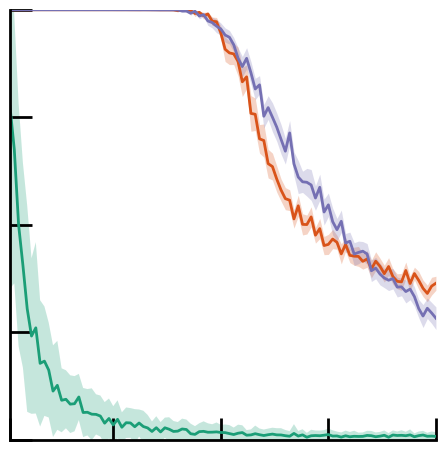

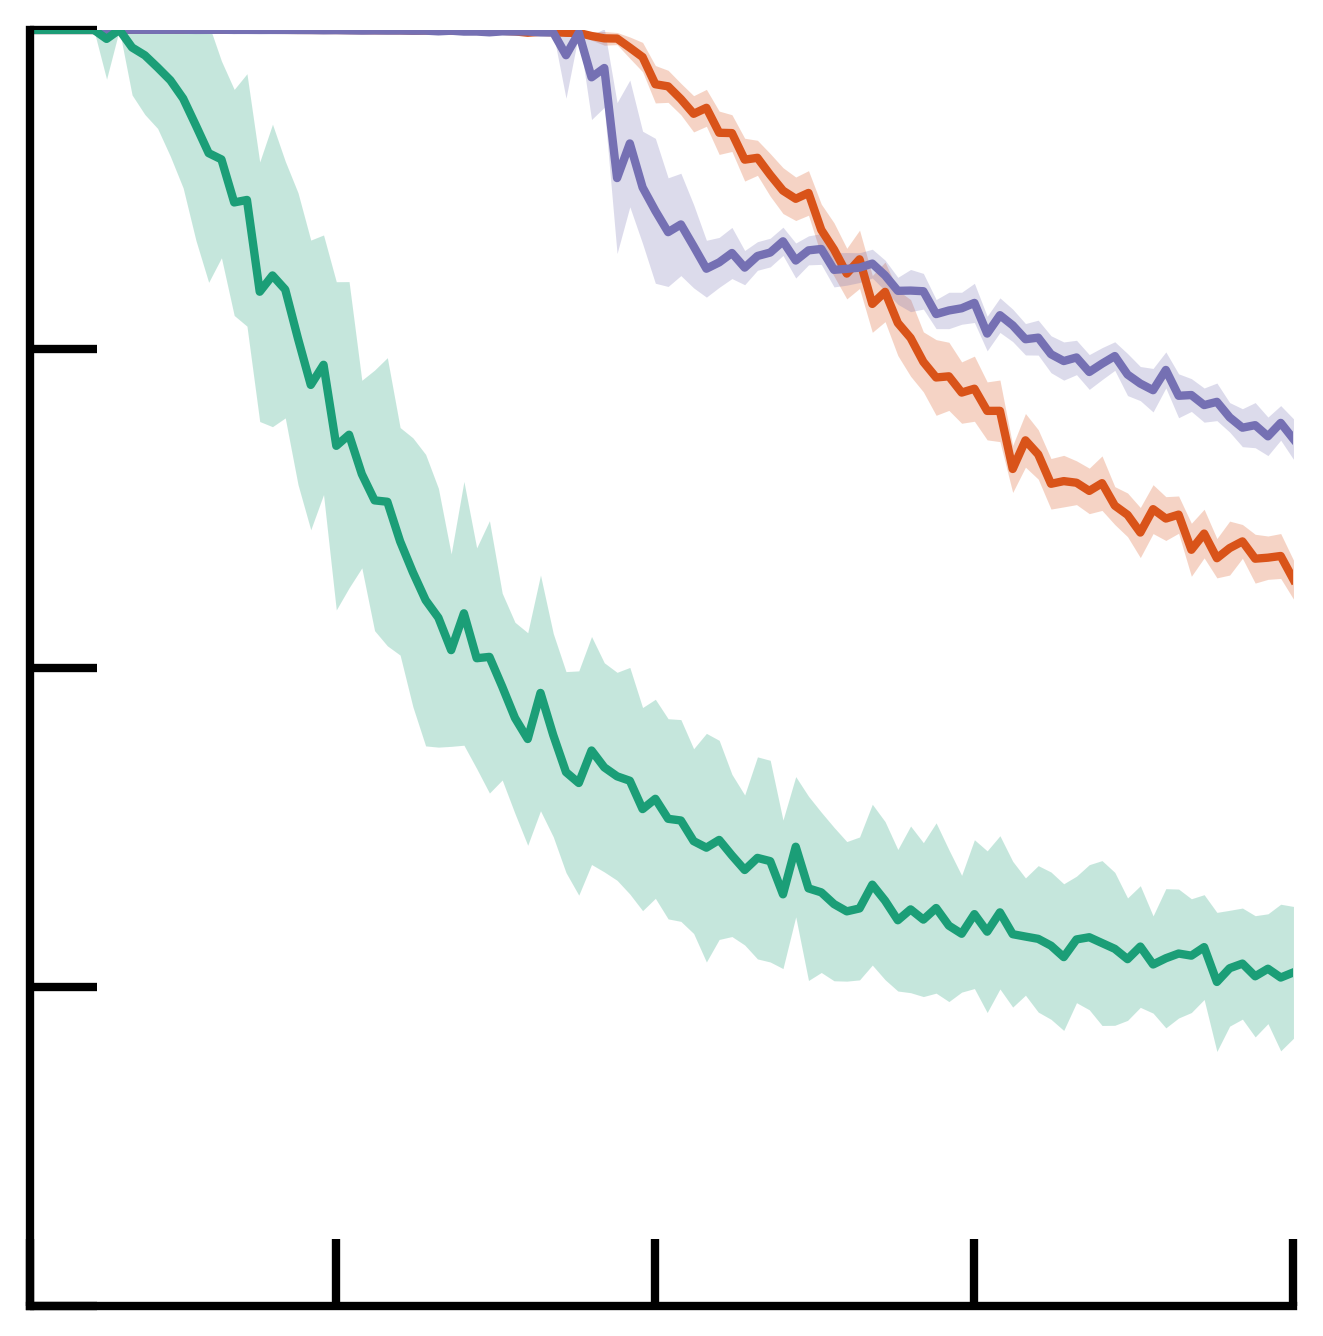

In [16]:
style = PlotStyle()
comparison_model_labels = ["Separated", "Separated (Circuit implementation)", "Non-separated"]
comparison_model_colors = [separatedColor, circuitColor, baselineColor]

# Loop through timepoints and create plots
for i, timepoint in enumerate(timepoints):
    period = "early" if i == 0 else "late"
    filename = f"model_comparison_presence_{period}_t{timepoint}.svg"
    model_data_list = [
        (presence_analysis_results["naive"]["n_high"][i], presence_analysis_results["naive"]["mean"][i], presence_analysis_results["naive"]["std"][i]),
        (presence_analysis_results["circuit"]["n_high"][i], presence_analysis_results["circuit"]["mean"][i], presence_analysis_results["circuit"]["std"][i]),
        (presence_analysis_results["poisson"]["n_high"][i], presence_analysis_results["poisson"]["mean"][i], presence_analysis_results["poisson"]["std"][i])
    ]
    fig, ax = plot_presence_assessed_curves(
        model_data_list=model_data_list,
        labels=comparison_model_labels,
        colors=comparison_model_colors,
        timepoint=timepoint,
        style=style,
        figsize=(6, 6),
        # save_path=figures_dir / f"model_comparison_presence_{period}_t{timepoint}.svg",
        show_std=True
    )
    if hide_label:
        hide_labels(ax)
    plt.show()
    
    fig.savefig(figures_dir / filename, bbox_inches='tight', format='svg')

logger.info(f"Model comparison plots saved to {figures_dir}")

### Plotting presence accuracy score heatmaps:

Computing heatmaps. This can takes a few minutes.


In [17]:
from sympy import E


models_to_process = ["poisson", "naive", "circuit"]
presence_accuracy_heatmaps = {}
model_theta_data = {}
logger.setLevel(logging.INFO)  # Set logger to INFO level to see computation logs
for model_key in models_to_process:
    try:
        # raise Exception("Skipping to heatmap computation")
        # if model_key == "poisson":
        #     raise Exception("Skipping Poisson model for heatmap computation")
        with h5py.File(output_base_dir / f"{model_key}_presence_hm.h5", "r") as f:
            presence_accuracy_heatmaps[model_key] = f["heatmap"][:]
            logger.info(f"Loaded heatmap for {model_key.capitalize()} model from file")
    except:
        logger.info(f"Computing heatmap for {model_key.capitalize()} model...")
        if model_key == "poisson":
            # Compute rank-based accuracy heatmap for Poisson model
            # presence_accuracy_heatmaps[model_key] = compute_rankacc_heatmap(
            presence_accuracy_heatmaps[model_key] = compute_binarized_auc_heatmap(
                model_concentration_data[model_key],
                t_start=0,
                n_timepoints=n_timepoint,
                threshold=20
            )
            logger.info("Computed rank accuracy for Poisson model")
        else:
            # Compute AUC heatmap for Naive and Circuit models (if Theta is available)
            theta_all, _ = collect_theta_all(model_configs[model_key]["output"])
            model_theta_data[model_key] = theta_all
            presence_accuracy_heatmaps[model_key] = compute_auc_heatmap(
                theta_all,
                t_start=0,
                n_timepoints=n_timepoint
            )
            logger.info(f"Computed AUC for {model_key.capitalize()} model")

11:57:09 - present_sweep_analysis - INFO - Loaded heatmap for Poisson model from file
11:57:09 - present_sweep_analysis - INFO - Loaded heatmap for Naive model from file
11:57:09 - present_sweep_analysis - INFO - Loaded heatmap for Circuit model from file


11:57:09 - present_sweep_analysis - INFO - Using color scale: vmin=0.500, vmax=1.000
11:57:09 - present_sweep_analysis - INFO - Figure for poisson model saved as SVG.
11:57:10 - present_sweep_analysis - INFO - Figure for naive model saved as SVG.
11:57:10 - present_sweep_analysis - INFO - Figure for circuit model saved as SVG.


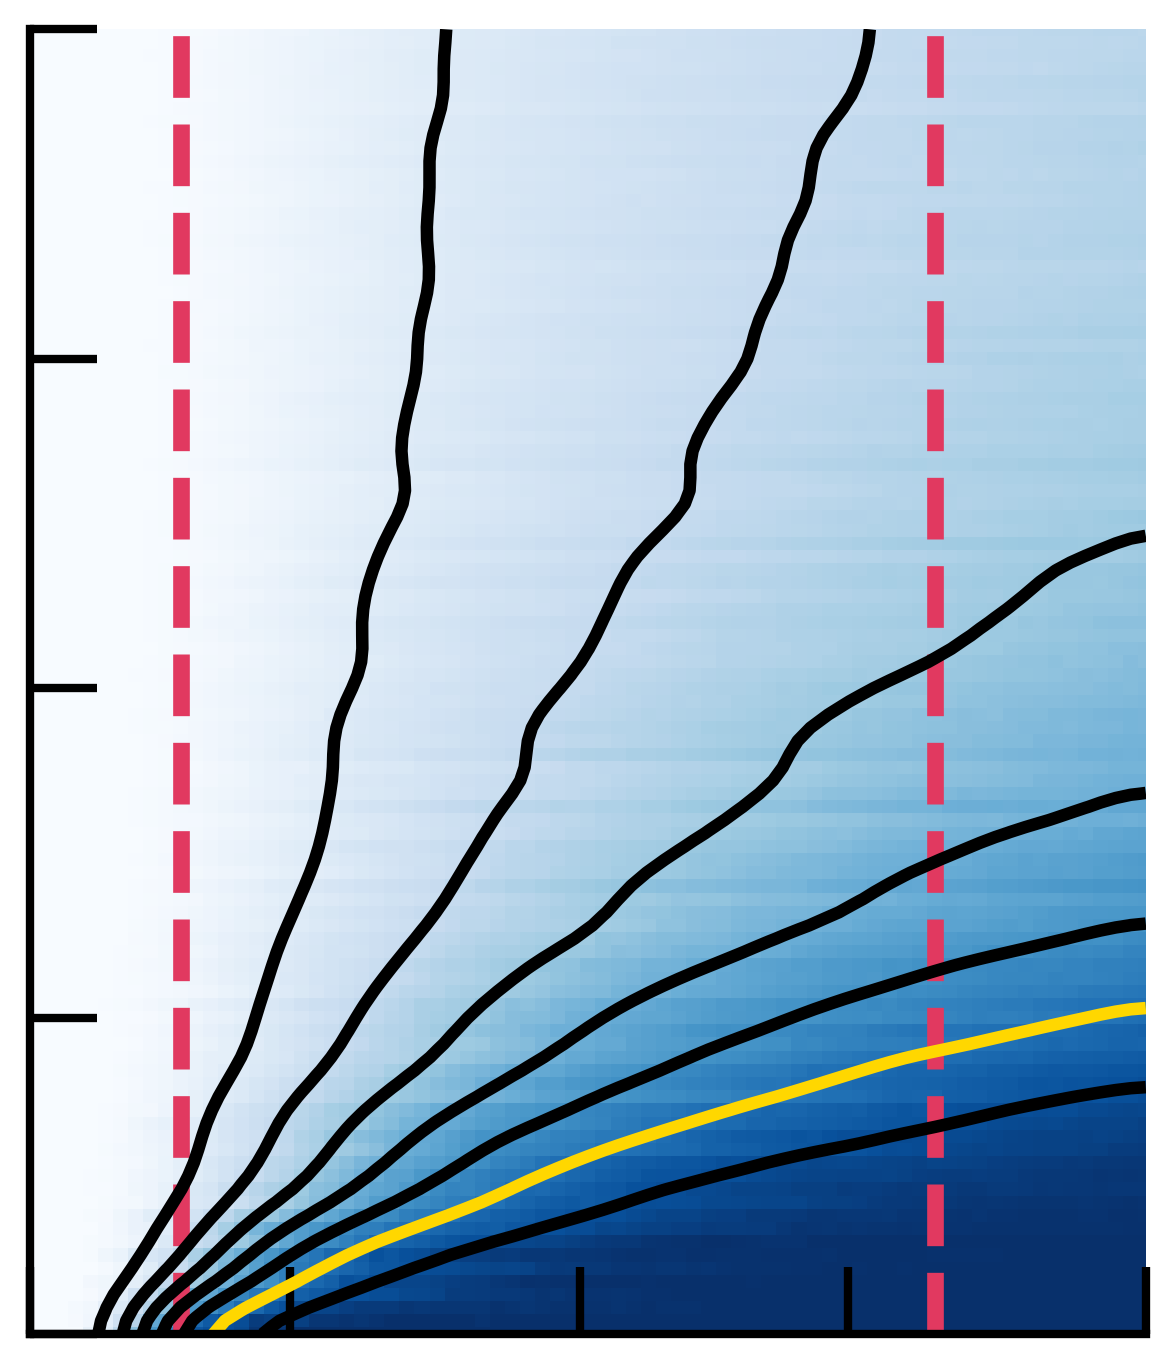

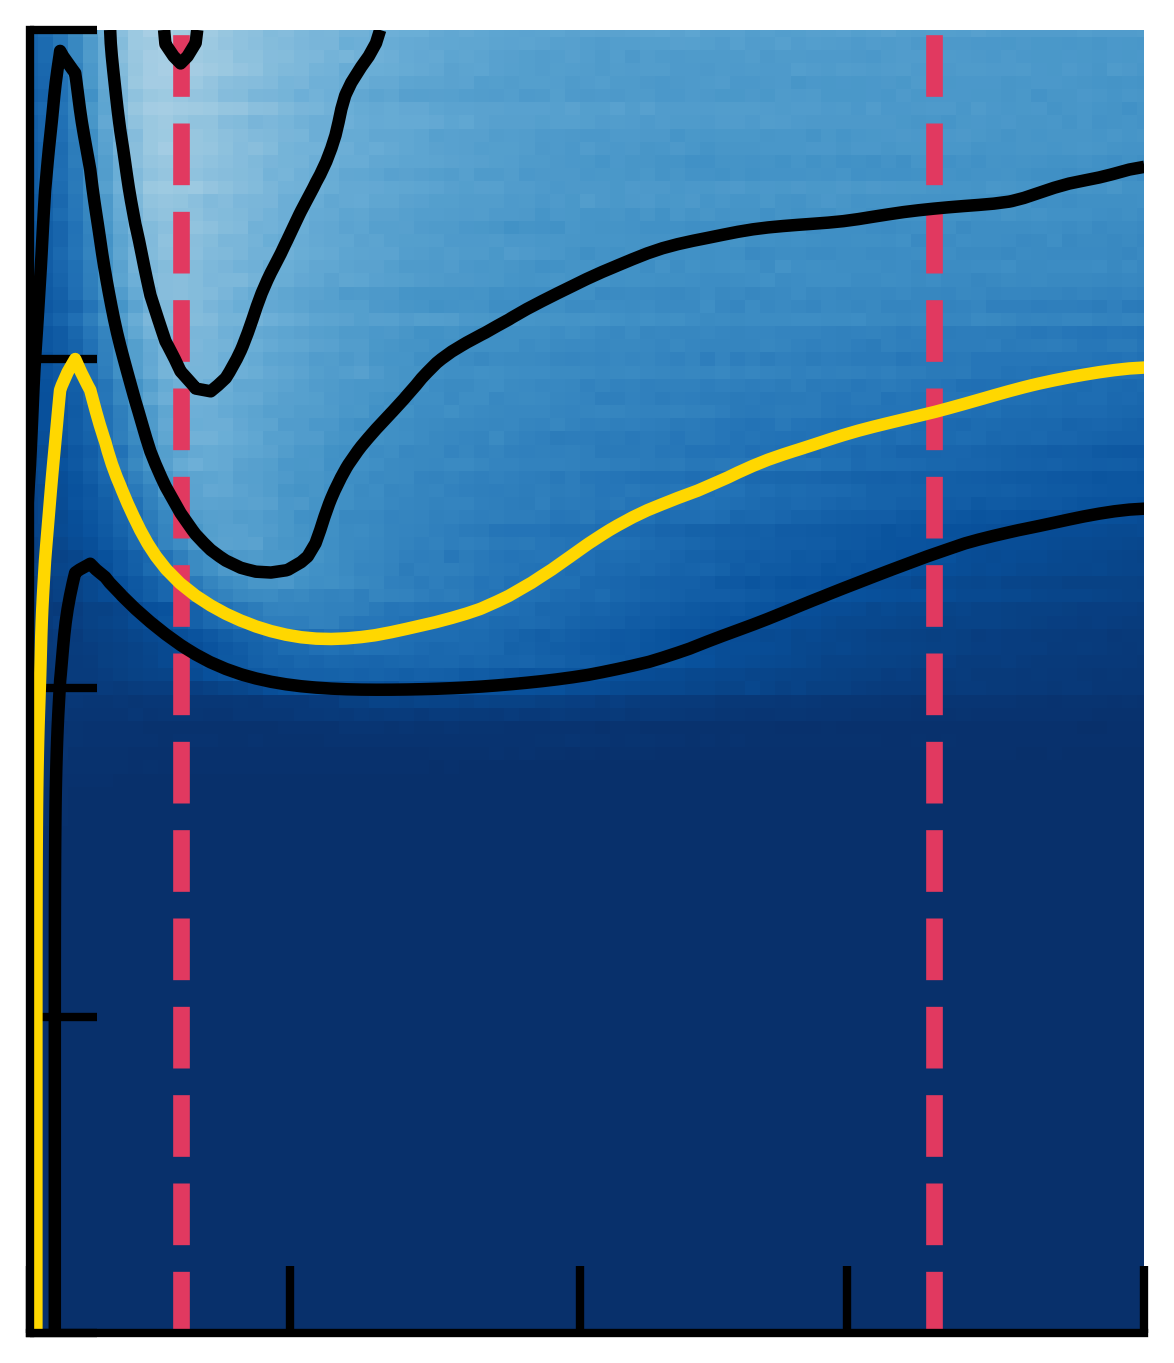

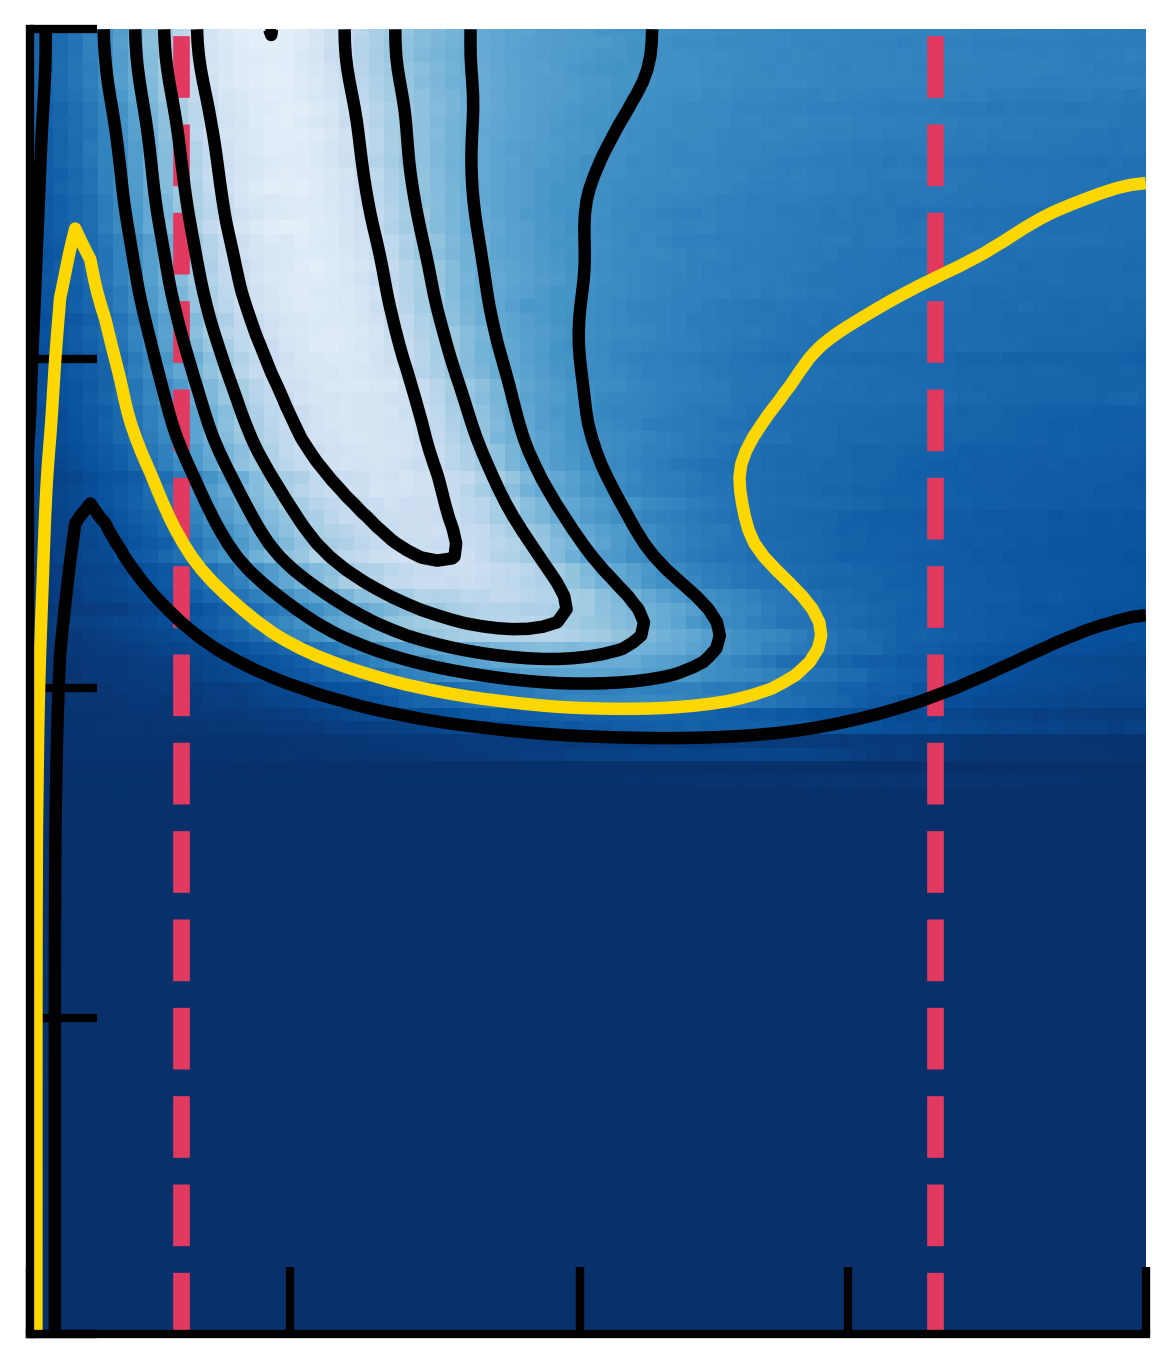

In [18]:
# # Determine global color scale for consistency
# if hm_auc_naive is not None:
#     # Use the same scale for both heatmaps
#     vmin = min(np.nanmin(hm_rank_poisson), np.nanmin(hm_auc_naive))
#     vmax = max(np.nanmax(hm_rank_poisson), np.nanmax(hm_auc_naive))
# else:
#     vmin, vmax = np.nanmin(hm_rank_poisson), np.nanmax(hm_rank_poisson)

from pygments import highlight


vmin, vmax = 0.5, 1.0
logger.info(f"Using color scale: vmin={vmin:.3f}, vmax={vmax:.3f}")

# Create a shared colormap normalization
norm = Normalize(vmin=vmin, vmax=vmax)

contour_levels_auc = [0.5, 0.5626, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0]
ticks_auc = ['0.5', '', '', '', '0.75', '', '0.875', '','1.0']
highlight_level_auc = 0.875

for model_key, title in zip(model_keys, model_titles):
    fig, ax = plot_accuracy_heatmap(
        presence_accuracy_heatmaps[model_key],
        title=title,
        xlabel="Time after odour onset (ms)",
        ylabel="Number of Odours Present",
        cmap="Blues",
        contour_levels=contour_levels_auc,
        vmin=vmin,
        vmax=vmax,
        highlight_level=highlight_level_auc,
        sigma=2,
        figsize=(8, 6),
        ver_markers=timepoints,
        aspect_ratio=1.15
    )
    

    hide_labels(ax) if hide_label else None

    cbar = colorbar_config(norm, fig, ax, contour_levels=contour_levels_auc,
                           ticks=ticks_auc)
    add_contour_lines_to_colorbar(cbar, contour_levels_auc, norm, highlight_level=highlight_level_auc,
                                  highlight_color='gold')
    # Uncomment the following line if you want to hide the colorbar
    cbar.ax.set_visible(False) if hide_label else None

    fig.savefig(figures_dir / f"{model_key}_accuracy.svg",
                format="svg", bbox_inches="tight")
    logger.info(f"Figure for {model_key} model saved as SVG.")

#### Saving heatmaps


In [19]:
# Save the heatmaps to HDF5 files for future reference
for model_key in models_to_process:
    file_name = f"{model_key}_presence_hm.h5"
    with h5py.File(output_base_dir / file_name, "w") as f:
        f.create_dataset("heatmap", data=presence_accuracy_heatmaps[model_key])
        f.create_dataset("n_high", data=np.arange(1, presence_accuracy_heatmaps[model_key].shape[0] + 1))
    logger.info(f"Saved heatmap for {model_key.capitalize()} model to {output_base_dir / file_name}")

11:57:10 - present_sweep_analysis - INFO - Saved heatmap for Poisson model to /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/present_sweep/sparse_binary/combined/poisson_presence_hm.h5
11:57:10 - present_sweep_analysis - INFO - Saved heatmap for Naive model to /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/present_sweep/sparse_binary/combined/naive_presence_hm.h5
11:57:10 - present_sweep_analysis - INFO - Saved heatmap for Circuit model to /Users/yizhenghe/Documents/Productivity_Coding/Simultaneous-detection-and-estimation-in-olfactory-sensing/data/present_sweep/sparse_binary/combined/circuit_presence_hm.h5
